# Lab 9: Convolutional Autoencoders for Image Processing



### Objectives
- This laboratory session focuses on implementing and understanding different types of autoencoders using the MNIST dataset. Students will explore convolutional autoencoders' architecture and working principles, while implementing dimensionality reduction and creating denoising autoencoders for image reconstruction. The lab includes visualization of latent space representations, comparison with traditional dimensionality reduction techniques, and extends to implementing variational autoencoders for probabilistic generative modeling.


### Dataset Description
The MNIST dataset consists of:
- 60,000 training images and 10,000 test images
- 28x28 grayscale images of handwritten digits (0-9)
- Each pixel value ranges from 0 (white) to 255 (black)
- Standardized format for machine learning research

### Tasks to be Performed
1. Data Preparation
   - Load and preprocess MNIST dataset
   - Create noisy versions of images for denoising tasks
   - Split data into training and validation sets

2. Convolutional Autoencoder Implementation
   - Design encoder architecture with convolutional layers
   - Implement corresponding decoder architecture

3. Training and Evaluation
   - Train the autoencoder
   - Monitor reconstruction loss
   - Visualize original vs reconstructed images

5. Denoising Implementation
   - Modify architecture for denoising
   - Train on noisy images
   - Evaluate denoising performance

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.decomposition import PCA

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### Data loading and transforming

In [115]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False,
    transform=transform,
    download=True
)


### Creating data loaders

In [116]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

### Function to add noise

In [117]:
# Function to add noise to images
def add_noise(images, noise_factor=0.3):
    noisy_images = images + noise_factor * torch.randn(*images.shape)
    return torch.clip(noisy_images, 0., 1.)

In [118]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Convolutional Autoencoder Architecture

#### Autoencoders
- Autoencoders is an unsupervised learning technique to learn the representation of data. An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”.

- Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name. The auto in autoencoder means it will encode the data which it is fed. This model will have the same data as input and output.
- Autoencoder will learn a summary or compression of input also called as latent space representation

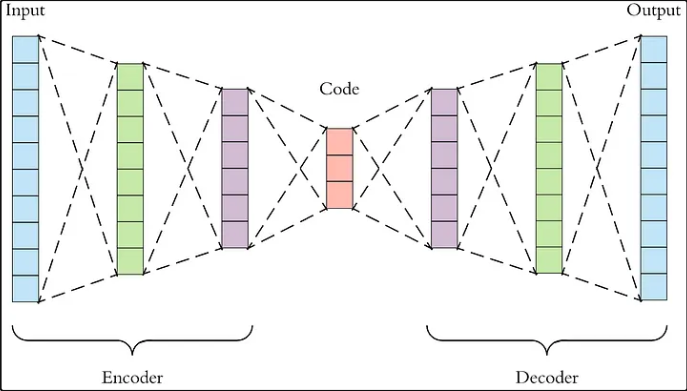

The autoencoders consist of two blocks:
- Encoder
- Decoder

The encoder is a network which will compress the input data into a smaller representation. The decoder is a network which will decompress the compressed data to generate the original input

In [119]:
### Convolutional Autoencoder Architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  # 7x7
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),  # 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # 28x28
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [135]:
model = ConvAutoencoder()
model = model.to(device)

print(model)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


### Training Function

In [120]:
### Training Function
def train_autoencoder(model, train_loader, num_epochs=10, learning_rate=1e-3):

    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            
            # Forward pass
            output = model(data)
            loss = criterion(output, data)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')
    
    return train_losses

# Initialize and train the model

losses = train_autoencoder(model, train_loader)

Epoch [1/10], Loss: 0.534940
Epoch [2/10], Loss: 0.472225
Epoch [3/10], Loss: 0.469425
Epoch [4/10], Loss: 0.468190
Epoch [5/10], Loss: 0.467412
Epoch [6/10], Loss: 0.466877
Epoch [7/10], Loss: 0.466443
Epoch [8/10], Loss: 0.466120
Epoch [9/10], Loss: 0.465860
Epoch [10/10], Loss: 0.465630


### Visualization Functions

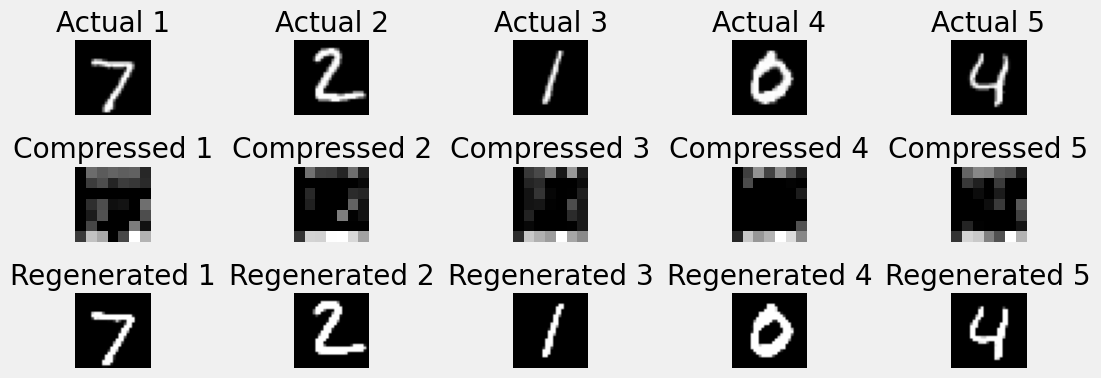

In [132]:
### Visualization Functions
def plot_reconstruction(model, test_loader, num_images=5):
    model.eval()
    with torch.no_grad():
        data = next(iter(test_loader))[0][:num_images]
        data = data.to(device)
        encoded_data = model.encoder(data)
        reconstruction = model(data)
        
        # Plot original and reconstructed images
        fig, axes = plt.subplots(3, num_images, figsize=(12, 4))
        for i in range(num_images):
            axes[0, i].set_title(f'Actual {i+1}')
            axes[0, i].imshow(data.cpu()[i][0], cmap='gray')
            axes[0, i].axis('off')
            
            axes[1, i].set_title(f'Compressed {i+1}')
            axes[1, i].imshow(encoded_data.cpu()[i][0], cmap='gray')
            axes[1, i].axis('off')
            
            axes[2, i].set_title(f'Regenerated {i+1}')
            axes[2, i].imshow(reconstruction.cpu()[i][0], cmap='gray')
            axes[2, i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Visualize reconstructions
plot_reconstruction(model, test_loader)

### Now, we will add noise to train image and then train model to remove that noise from image.

In [113]:
noise_factor = 0.9

### Training denoising autoencoder

In [110]:
def train_denoising_autoencoder(model, train_loader, noise_factor=noise_factor, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            
            # Add noise to the input images (on the same device as data)
            noisy_data = data + noise_factor * torch.randn(*data.shape).to(device)
            noisy_data = torch.clamp(noisy_data, 0., 1.)
            
            # Forward pass
            output = model(noisy_data)
            loss = criterion(output, data)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

# Train denoising autoencoder
denoising_model = ConvAutoencoder()
train_denoising_autoencoder(denoising_model, train_loader)

Epoch [1/10], Loss: 0.980337
Epoch [2/10], Loss: 0.967982
Epoch [3/10], Loss: 0.967914
Epoch [4/10], Loss: 0.967910
Epoch [5/10], Loss: 0.967888
Epoch [6/10], Loss: 0.967776
Epoch [7/10], Loss: 0.967769
Epoch [8/10], Loss: 0.967703
Epoch [9/10], Loss: 0.964994
Epoch [10/10], Loss: 0.625068


### Visualization of Denoising Results

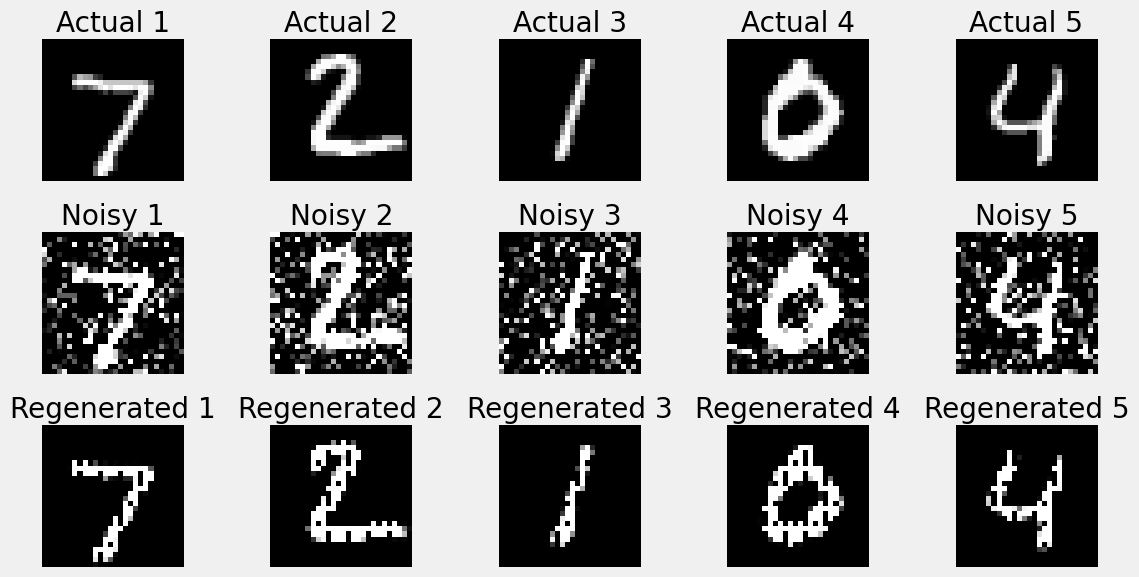

In [134]:
### Visualization of Denoising Results
def plot_denoising_results(model, test_loader, noise_factor=noise_factor, num_images=5):
    model.eval()
    with torch.no_grad():
        data = next(iter(test_loader))[0][:num_images]
        noisy_data = add_noise(data, noise_factor)
        noisy_data = noisy_data.to(device)
        reconstruction = model(noisy_data)
        
        # Plot original, noisy, and reconstructed images
        fig, axes = plt.subplots(3, num_images, figsize=(12, 6))
        for i in range(num_images):
            axes[0, i].set_title(f'Actual {i+1}')
            axes[0, i].imshow(data[i][0], cmap='gray')
            axes[0, i].axis('off')
            
            axes[1, i].set_title(f'Noisy {i+1}')
            axes[1, i].imshow(noisy_data.cpu()[i][0], cmap='gray')
            axes[1, i].axis('off')
            
            axes[2, i].set_title(f'Regenerated {i+1}')
            axes[2, i].imshow(reconstruction.cpu()[i][0], cmap='gray')
            axes[2, i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Visualize denoising results
plot_denoising_results(denoising_model, test_loader)